<a class="anchor" id="0"></a>
# **Featur correlation**

<a class="anchor" id="0.1"></a>
# **Table of Contents**


1. [Introduction to k Nearest Neighbours Algorithm](#1)
2. [k Nearest Neighbours intuition](#2)
3. [How to decide the number of neighbours in kNN](#3)
4. [Eager learners vs lazy learners](#4)



#### Libraries And Settings

In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from datetime import timedelta

# Import Own modules
import context # it can oly import context.py when contained in the same folder as demmi.py
from paths import path_output
from demmi_ex_dict import demmi_ex, demmi_ex_short
from acceleration import put_margins_around_ex, resample, align_timestamp
from feature_dev import feature_development
from RUN_1_acceleration import EXERCISES, MARGIN_SECONDS, PATH_DATA, ENABLE_RESAMPLE, load_data, load_borg, format_data, plot_exercises

# Allow several outputs in same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Settings
import warnings
warnings.filterwarnings('ignore')

dir_path is at:  /Users/julien/My Drive/20_STUDIUM/ACLS/05 MODULE/TM/mhealth/studies/imove/analysis/acceleration


#### Load data

In [2]:
# 1) acceleration
df_raw  = load_data(path_data=PATH_DATA, mode='all')  # all 60 pat

In [3]:
# 2a) acc_allEx_allPat_margin0_resampleTrue
acc_allEx_allPat_margin0_resampleTrue = pd.read_csv('acc_allEx_allPat_margin0_resampleTrue.csv', index_col=False)  
#data = acc_allEx_allPat_margin0_resampleTrue
#data['Patient'] = data['Patient'].astype(str)
#data.loc[:,'Patient'] = data['Patient'].str.rjust(3, "0") # add trailing zeros

In [4]:
acc_allEx_allPat_margin0_resampleTrue.head(1)

,timestamp,A,AX,AY,AZ,DeMortonDay,Side,Patient,DeMortonLabel,time
0,2018-08-02 13:55:42+00:00,285.34915,1.187675,240.53781,153.47899,2,left,1,2a,0 days 00:00:00


In [5]:
# 2b) df_aligned_ex12 = format_data(df=df_raw, exercises=['12'], margin_seconds=0) # ex 12

In [6]:
#df_aligned_ex12.info()
#df_aligned_ex12.head(2)

In [7]:
# 3a) scores_disagg (not important)
scores_disagg = pd.read_csv('scores_disagg.csv')  
# 3b) scores_agg 
scores_agg = pd.read_csv('scores_agg.csv')  

In [8]:
# 4a) Borg (i.e. from borg_bmi_age.csv). 60 rows.
borg = load_borg(PATH_DATA) # load it from specified folder in function definition.

# **2. Exploratory Data Analysis of scores_agg** <a class="anchor" id="2"></a>
scores_agg: main cols: Exercise_number, Patient. Cols DeMortonDay and Side have been aggregated with mean.
scores_agg is thereafter named df (for simplicity)

[Table of Contents](#0.1)


In [9]:
df = scores_agg
# df = df.set_index(['Patient','Exercise_number']) # dont do it
df['Patient'] = df['Patient'].astype(str)
df.loc[:,'Patient'] = df['Patient'].str.rjust(3, "0") # add trailing zeros
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Exercise_number      210 non-null    object 
 1   Patient              210 non-null    object 
 2   Std Dev of A         210 non-null    float64
 3   BMI                  210 non-null    float64
 4   Kinetic energy       210 non-null    float64
 5   Max. Frequency       210 non-null    float64
 6   Exertion             210 non-null    float64
 7   counts               210 non-null    int64  
 8   Exercise             210 non-null    object 
 9   sex                  210 non-null    object 
 10  ideal_bmi_deviation  210 non-null    float64
dtypes: float64(6), int64(1), object(4)
memory usage: 18.2+ KB


In [10]:
df.shape # Dimensions 
df.head(3) # Print first 5 rows of df

(210, 11)

,Exercise_number,Patient,Std Dev of A,BMI,Kinetic energy,Max. Frequency,Exertion,counts,Exercise,sex,ideal_bmi_deviation
0,12,001,30.817592,21.469150,2.318062e+05,1.675337,1.666667,3,12: Gehen,Male,4.572753
1,12,002,30.079820,26.370238,1.567620e+06,2.046280,0.500000,4,12: Gehen,Female,2.183315
2,12,003,39.282420,29.903029,7.254029e+06,2.421437,3.000000,5,12: Gehen,Female,5.716106


In [11]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Std Dev of A,210.0,59.444470,6.787361e+01,1.666787,19.582923,33.650465,52.207696,3.221087e+02
BMI,210.0,25.264578,4.321330e+00,16.423650,22.019503,25.101082,28.256990,3.820018e+01
Kinetic energy,210.0,789202.209329,3.427167e+06,0.000000,0.000000,6613.899083,153574.201667,4.055145e+07
Max. Frequency,210.0,2.407709,1.212328e+00,0.390886,1.664660,2.100745,2.846661,7.932976e+00
Exertion,210.0,0.427381,9.392854e-01,-1.800000,0.000000,0.200000,1.000000,3.000000e+00
counts,210.0,3.719048,1.435076e+00,1.000000,3.000000,4.000000,5.000000,6.000000e+00
ideal_bmi_deviation,210.0,3.422014,2.462923e+00,0.051372,1.637129,3.109728,4.783400,1.401326e+01


In [12]:
# Descriptive statistics (of categorical variables)
df.describe(include=object).T

,count,unique,top,freq
Exercise_number,210,4,12,55
Patient,210,55,001,4
Exercise,210,4,12: Gehen,55
sex,210,2,Male,122


In [13]:
# Count NANs per feature
df.isnull().sum()

Exercise_number        0
Patient                0
Std Dev of A           0
BMI                    0
Kinetic energy         0
Max. Frequency         0
Exertion               0
counts                 0
Exercise               0
sex                    0
ideal_bmi_deviation    0
dtype: int64

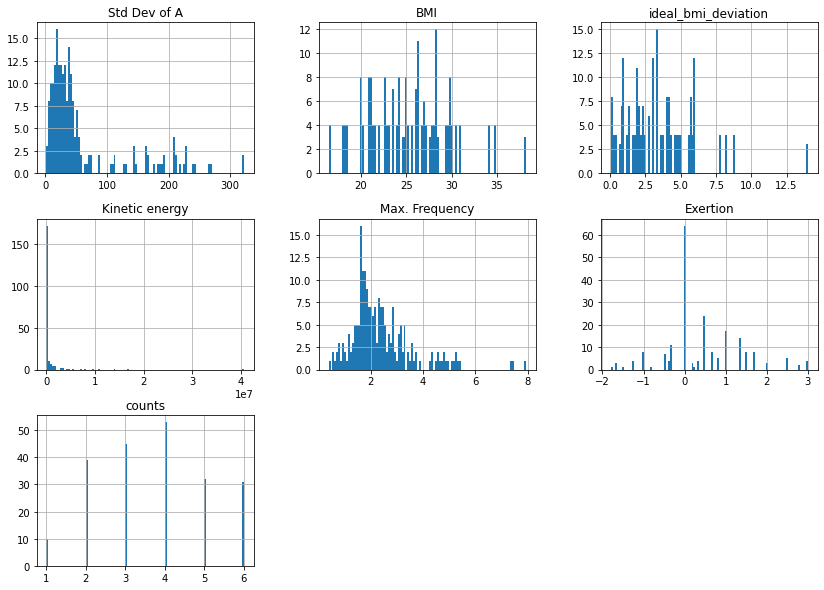

In [14]:
# Histograms of: age, avg_glucose_level, bmi
df[['Std Dev of A','BMI', 'ideal_bmi_deviation', 'Kinetic energy', 'Max. Frequency', 'Exertion', 'counts']].hist(bins=100, figsize=(14,10));

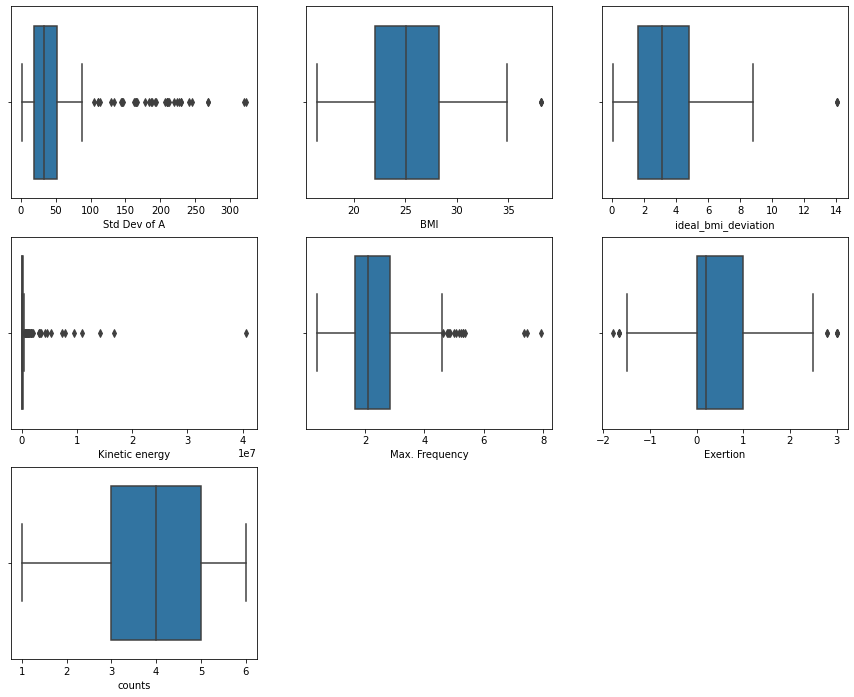

In [15]:
# Checking distributions
plt.figure(figsize=(15, 12))
plt.subplot(3,3,1)
sns.boxplot( x=df["Std Dev of A"] );
plt.subplot(3,3,2)
sns.boxplot( x=df["BMI"] );
plt.subplot(3,3,3)
sns.boxplot( x=df["ideal_bmi_deviation"] );
plt.subplot(3,3,4)
sns.boxplot( x=df["Kinetic energy"] );
plt.subplot(3,3,5)
sns.boxplot( x=df["Max. Frequency"] );
plt.subplot(3,3,6)
sns.boxplot( x=df["Exertion"] );
plt.subplot(3,3,7)
sns.boxplot( x=df["counts"] );

# **1. Check and Remove outliers** <a class="anchor" id="1"></a>
Above we saw that bmi has extreme outliers. The outliers that deviate more than (eg) 4 sd will be excluded.


[Table of Contents](#0.1)

## Check Kinetic energy-outiers

In [16]:
# calculate z-scores for bmi in df (scores_ALL_ex)
z = np.abs(stats.zscore(df["Kinetic energy"]))
z
threshold = 1 # 2 # 4 sd

0      0.163029
1      0.227674
2      1.890855
3      0.151326
4      0.143677
         ...   
205    0.229399
206    0.230829
207    0.211477
208    0.229618
209    0.230805
Name: Kinetic energy, Length: 210, dtype: float64

In [17]:
outliers_i = np.where(z > threshold) # indices of outliers
# print(outliers_i)
outliers_count = sum(z > threshold)
print("Outliers of 'Kinetic energy' to be excluded: ", outliers_count)

Outliers of 'Kinetic energy' to be excluded:  9


In [18]:
# Investigate outliers of Kinetic energy
kinE_outliers = df.iloc[outliers_i]
kinE_outliers

,Exercise_number,Patient,Std Dev of A,BMI,Kinetic energy,Max. Frequency,Exertion,counts,Exercise,sex,ideal_bmi_deviation
2,12,003,39.282420,29.903029,7.254029e+06,2.421437,3.000000,5,12: Gehen,Female,5.716106
24,12,025,44.072758,30.387105,1.663879e+07,1.796006,0.000000,6,12: Gehen,Male,4.345202
33,12,034,53.240083,34.865702,1.089572e+07,1.718398,0.666667,3,12: Gehen,Male,8.823799
47,12,050,51.972594,16.423650,1.417344e+07,1.760655,0.800000,5,12: Gehen,Female,7.763273
48,12,054,38.251207,23.999459,4.055145e+07,1.588744,-1.666667,6,12: Gehen,Female,0.187464
49,12,055,64.834377,29.629630,7.733109e+06,1.884728,1.333333,6,12: Gehen,Male,3.587726
50,12,056,49.745340,27.777778,4.531369e+06,1.802269,0.000000,5,12: Gehen,Male,1.735874
60,15,007,212.592442,25.142857,5.338716e+06,2.711125,-0.333333,6,15: Springen an Ort,Male,0.899046
87,15,042,228.992577,27.239224,9.475714e+06,1.614414,0.000000,2,15: Springen an Ort,Male,1.197321


Ex 12 Gehen is responsible for a lot of those outliers in Kinetic Energy. 

In [19]:
# Patients of those outliers
kinE_outliers_patients = list(kinE_outliers.Patient)
kinE_outliers_patients

['003', '025', '034', '050', '054', '055', '056', '007', '042']

In [20]:
# Outliers in df_aligned of ex 12
df_aligned_ex12 = format_data(df=df_raw, exercises=['12'], margin_seconds=0)
df_aligned_ex12_outliers = df_aligned_ex12.query('Patient == @kinE_outliers_patients')

Contained exercises:  ['12' nan '3b' '4' '1' '2a' '2b' '2c' '2d' '3a' '7' '8' '9' '11' '13' '14'
 '15']
Contained Days:  ['2' '3' '1' nan]
Contained sides:  ['left' 'right']
Contained patients:  ['001' '002' '003' '004' '005' '006' '007' '008' '009' '010' '011' '012'
 '013' '014' '015' '016' '017' '018' '019' '020' '021' '022' '023' '024'
 '025' '026' '027' '028' '029' '030' '031' '032' '033' '034' '035' '036'
 '037' '038' '039' '040' '041' '042' '043' '044' '046' '048' '049' '050'
 '054' '055' '056' '057' '058' '059' '060']


It seems that Ex 12 Gehen produces a lot of outliers for Kinetic Energy. Assumption: If somebody walks for a long distance, his/her Kinetic Energy accumulates with the time. A better measurement would be Leistung = Arbeit/Zeit. We could now check how long for these patients walked in comparison to the other patients. In the following the respective graphs. The outliers seem to walk for longer time, but it's difficult to judge by these plots. Needs proper walking duration analysis.

In [21]:
#plot_exercises(df=df_aligned, exercises=['12'])
#plt.show()

In [22]:
# Outliers in df_aligned of ex 12
#plot_exercises(df=df_aligned_ex12_outliers, exercises=['12'])
#plt.show()

## Removal of Kinetic energy-outiers

In [23]:
# remove obs of bmi-outliers
df = df.loc[z < threshold,:] # subset obs, that are not bmi-outliers
#df = df.reset_index(drop=True)

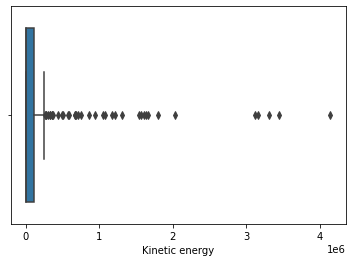

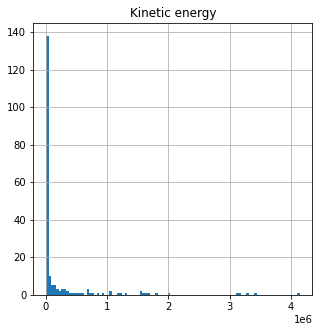

In [24]:
# Check new distribution of Kinetic energy
sns.boxplot( x=df["Kinetic energy"] );
df[['Kinetic energy']].hist(bins=100, figsize=(5,5));

# **1. Correlation** <a class="anchor" id="1"></a>

In [25]:
df = df.drop(["BMI", 'counts'], 1) # drop col counts


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 209
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Exercise_number      201 non-null    object 
 1   Patient              201 non-null    object 
 2   Std Dev of A         201 non-null    float64
 3   Kinetic energy       201 non-null    float64
 4   Max. Frequency       201 non-null    float64
 5   Exertion             201 non-null    float64
 6   Exercise             201 non-null    object 
 7   sex                  201 non-null    object 
 8   ideal_bmi_deviation  201 non-null    float64
dtypes: float64(5), object(4)
memory usage: 15.7+ KB


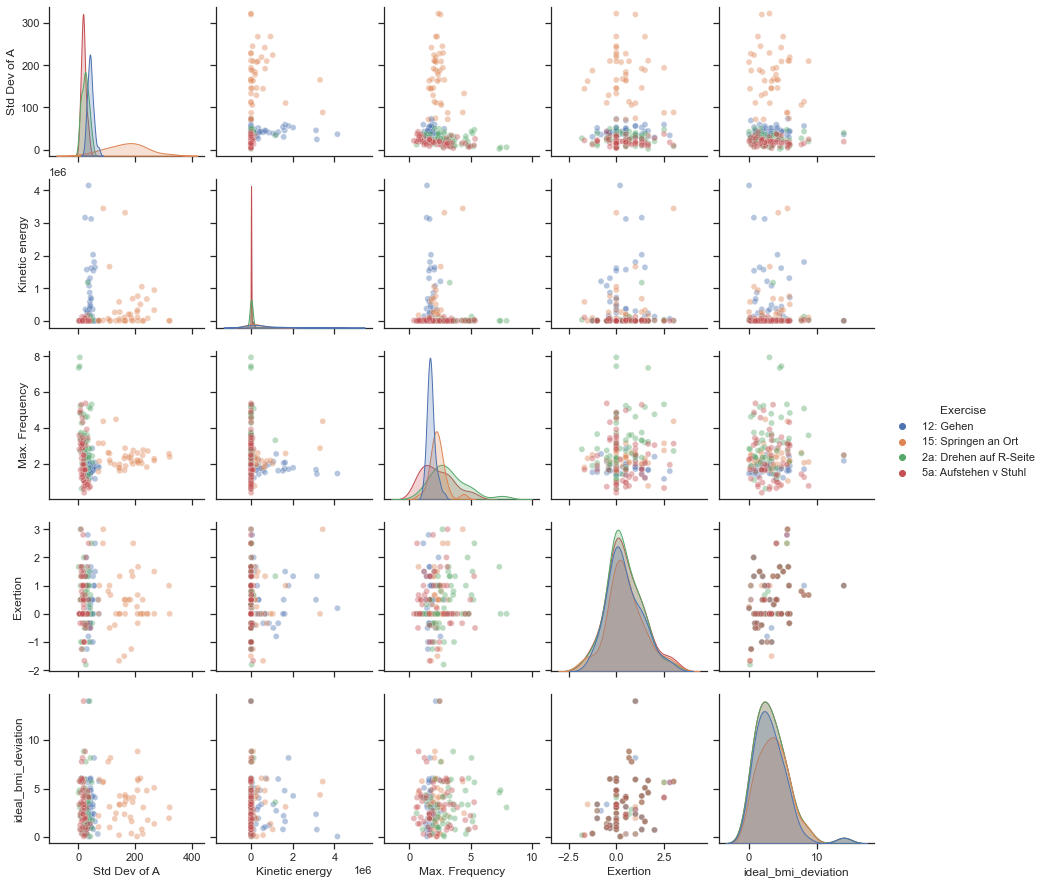

In [27]:
import seaborn as sns
sns.set_theme(style="ticks")

# by "Exercise" (without regression line)
sns.pairplot(df, hue="Exercise", plot_kws = { 'alpha': 0.4 })

path_save = Path(path_output, 'plots/corr_features/corr_features_HUE_exercise.png')
plt.savefig(path_save)

In [28]:
# by "Exercise" (without regression line)
#sns.pairplot(df, hue="Exercise",  kind="reg", plot_kws={'line_kws':{'color':'red'}})
# is not as expected

LinAlgError: singular matrix

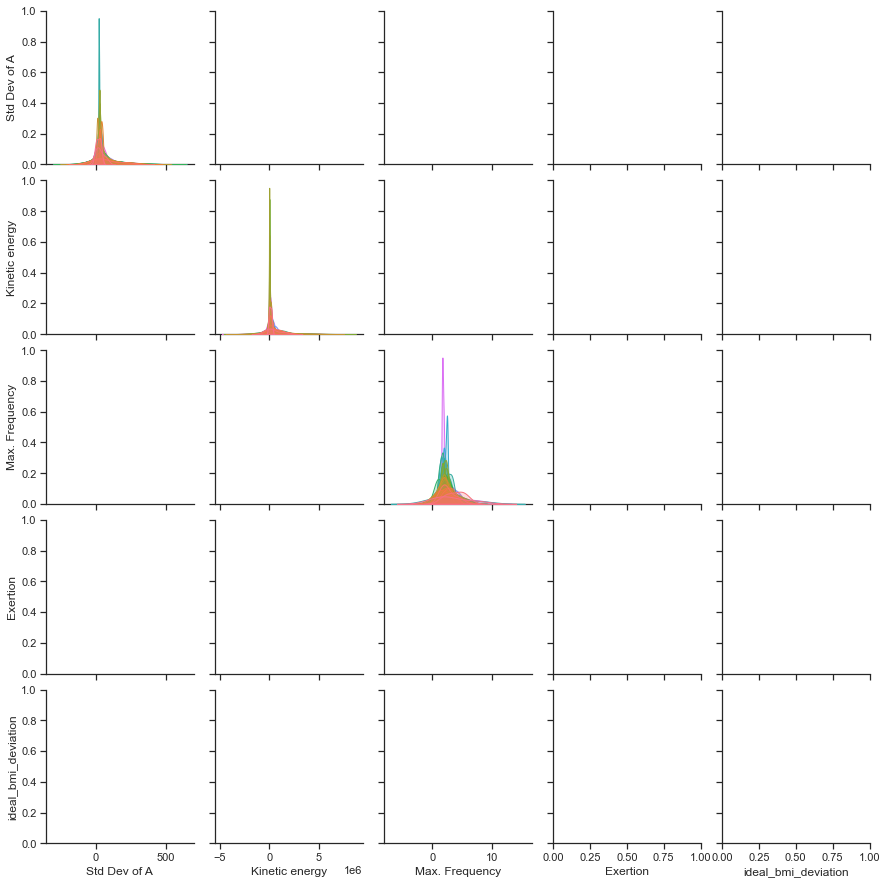

In [29]:
# by "Patient"
sns.pairplot(df, hue="Patient")
#path_save = Path(path_output, 'plots/corr_features/corr_features_HUE_patient.png')
#plt.savefig(path_save)

# KEINE AHNUNG WARUM, NACH DEM OUTLIER-REMOVAL DIESER PLOT NICHT MEHR FUNKTIONIERT.....

#### Pearson's Correlation heatmap between all features
Note: scale shoes only values between -0.5 and 0.5 (for better visibility)


<Figure size 864x720 with 0 Axes>

Text(0.5, 1.0, 'Correlation Heatmap')

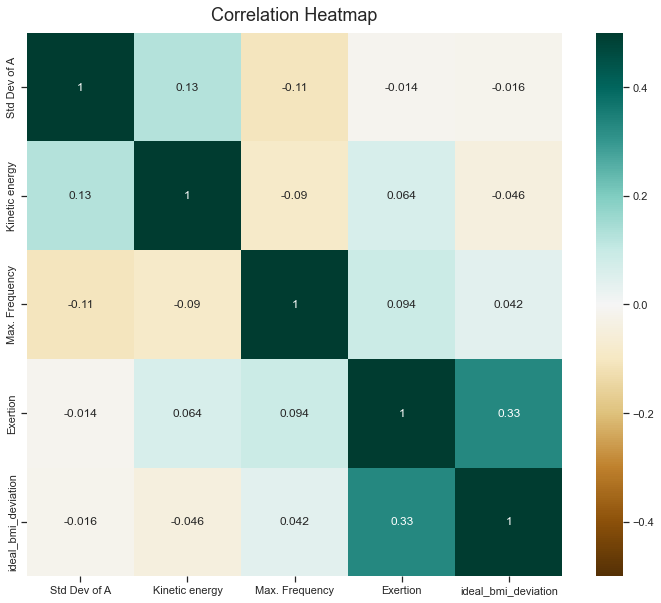

In [41]:
plt.figure(figsize=(12,10)) 
heatmap = sns.heatmap(df.corr(), vmin = -0.5, vmax=0.5,
            annot=True, cmap ='BrBG'); 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
path_save = Path(path_output, 'plots/corr_features/correlation_heatmap.png')
plt.savefig(path_save)

## Interpretation:

In [31]:
df.corr()

,Std Dev of A,Kinetic energy,Max. Frequency,Exertion,ideal_bmi_deviation
Std Dev of A,1.000000,0.128201,-0.109212,-0.013860,-0.015732
Kinetic energy,0.128201,1.000000,-0.089573,0.063668,-0.046102
Max. Frequency,-0.109212,-0.089573,1.000000,0.093615,0.042051
Exertion,-0.013860,0.063668,0.093615,1.000000,0.329490
ideal_bmi_deviation,-0.015732,-0.046102,0.042051,0.329490,1.000000


# **3. Normalization (Scaling)** <a class="anchor" id="3"></a>
All features should be scaled for ML applications.


[Table of Contents](#0.1)


a

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [33]:
# Divide stroke df into its numerical and categorical features
X_num = df.select_dtypes(include=[float]) # subset of the 5 numerical features
X_cat = df.select_dtypes(include=[object]) # subset of the 2 categorical features: Exercise, Patient


In [34]:
X = StandardScaler().fit_transform(X_num) # output becomes: numpy-ndarray
# StandardScaler cannot guarantee balanced feature scales in the presence of outliers.
X

array([[-0.40733825, -0.01990452, -0.6134224 ,  1.3423934 ,  0.48021794],
       [-0.41830898,  2.07831643, -0.31168712,  0.07842531, -0.50223792],
       [-0.24585369,  1.66829806, -0.66093348, -0.82440904,  1.05890223],
       ...,
       [-0.50740954, -0.28008671, -0.62346593, -0.89663579, -0.62568222],
       [-0.38910582, -0.37751143, -1.28529773, -0.4632753 , -0.84320629],
       [-0.64034707, -0.38388768,  0.58121854, -0.4632753 , -0.97710708]])

[Go to Top](#0)

# **4. Predictor comparison** <a class="anchor" id="3"></a>
Left join: df with borg.

[Table of Contents](#0.1)

In [35]:
borg = borg.reset_index() # make patient_ID a normal col

In [36]:
# borg: from: borg_bmi_age.csv
df_pats = borg[["patient_ID", "age", "sex"]].copy()  #  "BMI"
df_pats.rename(columns = {'patient_ID':'Patient'}, inplace = True)
# df_pats.head()
df_pats.info(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  60 non-null     object 
 1   age      60 non-null     float64
 2   sex      60 non-null     object 
dtypes: float64(1), object(2)
memory usage: 1.5+ KB


In [37]:
data = df.copy()
data = data.loc[:, ~data.columns.isin(["Exercise", "sex"])] # exclude Exercise
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201 entries, 0 to 209
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Exercise_number      201 non-null    object 
 1   Patient              201 non-null    object 
 2   Std Dev of A         201 non-null    float64
 3   Kinetic energy       201 non-null    float64
 4   Max. Frequency       201 non-null    float64
 5   Exertion             201 non-null    float64
 6   ideal_bmi_deviation  201 non-null    float64
dtypes: float64(5), object(2)
memory usage: 12.6+ KB


In [38]:
merged = pd.merge(left=data, right=df_pats, how="left", on="Patient")
merged.head(1)

,Exercise_number,Patient,Std Dev of A,Kinetic energy,Max. Frequency,Exertion,ideal_bmi_deviation,age,sex
0,12,001,30.817592,231806.22,1.675337,1.666667,4.572753,71.2,Male


In [39]:
data_melt = merged.melt(id_vars=["Patient", "sex", "Exercise_number"],
value_name="Values", var_name="Predictor")
data_melt.head(1)
data_melt.Predictor.unique()

,Patient,sex,Exercise_number,Predictor,Values
0,001,Male,12,Std Dev of A,30.817592


array(['Std Dev of A', 'Kinetic energy', 'Max. Frequency', 'Exertion',
       'ideal_bmi_deviation', 'age'], dtype=object)

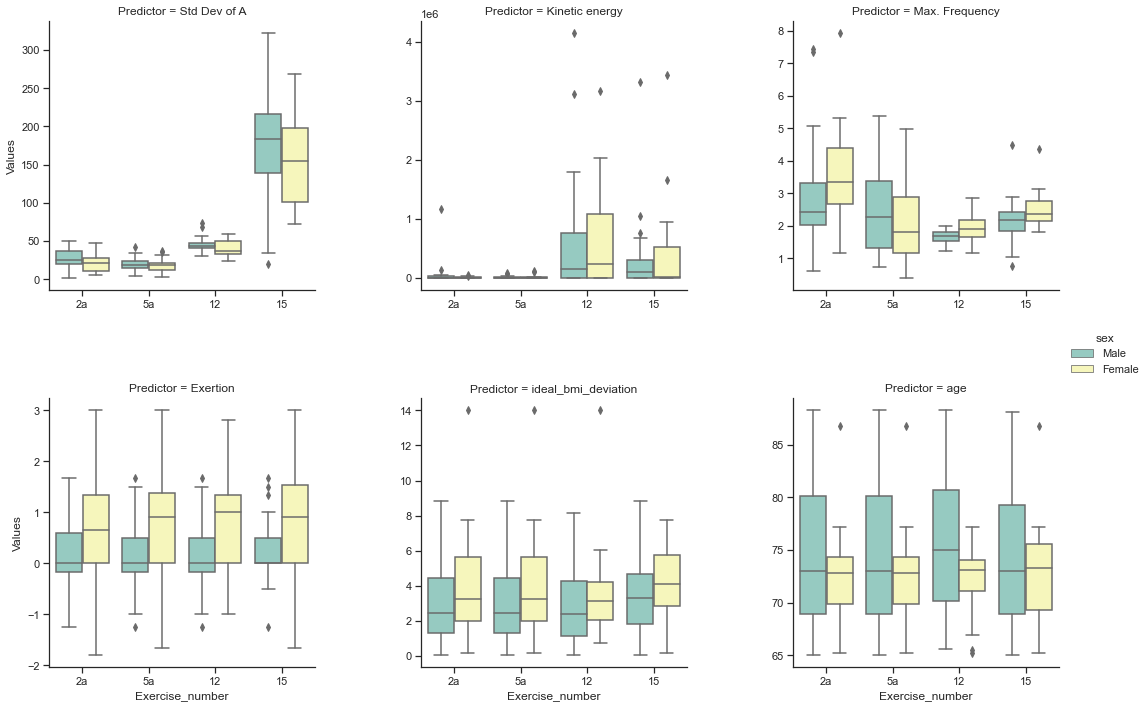

In [43]:
# Plot
g = sns.catplot(x="Exercise_number", y="Values", hue="sex", col="Predictor",
order=["2a", "5a", "12", "15"],
kind="box", data=data_melt, sharex=False, sharey=False,
palette="Set3", col_wrap=3)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

path_save = Path(path_output, 'plots/corr_features/predictor_comparison.png')
plt.savefig(path_save)
plt.show()